In [9]:
'''
#测试动态规整 fastdtw
import numpy as np
from scipy.spatial.distance import euclidean

from fastdtw import fastdtw

x = np.array([[1,1], [2,2], [3,3], [4,4], [5,5]])
y = np.array([[2,2], [3,3], [4,4]])
distance, path = fastdtw(x, y, dist=euclidean)
print(path)

[(0, 0), (1, 0), (2, 1), (3, 2), (4, 2)]


In [26]:
#调用get_alldata函数传入文件夹名称 实现json序列的角度获取
import os
import json
import numpy as np
import glob
import time
import math

class standardPoint:
    def __init__(self, x = None, y = None):
        self.x = x
        self.y = y
		
    def __sub__(self, other):
        return standardPoint(self.x - other.x, self.y - other.y)
        
    def norm(self):
        return math.sqrt(self.x ** 2 + self.y ** 2)
        
    def cos_points(self, other):#求两线的cos角，即两个肢体部位
        if self.norm()*other.norm() != 0:
            return (self.x * other.x + self.y * other.y) / (self.norm()*other.norm())
        else:
            return 0

#对一个动作（即一帧）进行标准化处理 输入一帧的XY序列 返回标准化后结果
def standardAction(Action):
    standardList = []
    coorcnt = 0
    x = 0.0
    y = 0.0

    for cor in Action:
        if 0 == coorcnt:
            x = cor
            coorcnt += 1
            continue
        if 1 == coorcnt:
            y = cor
            coorcnt =0
            standardList.append(standardPoint(x, y))
            continue
    return standardList

#输入一个标准化动作 返回该动作中蕴含的有效角度信息
def cul_angle(aStdAction):
    #print(aStdAction[24].x)
    Ang_List = []
    body = []
    # 部位向量值
    body.append(aStdAction[0] - aStdAction[1])  # 头颈
    body.append(aStdAction[5] - aStdAction[2])  # 肩膀
    body.append(aStdAction[2] - aStdAction[3])  # 右上臂
    body.append(aStdAction[3] - aStdAction[4])  # 右前臂    
    body.append(aStdAction[5] - aStdAction[6])  # 左上臂
    body.append(aStdAction[6] - aStdAction[7])  # 左前臂  
    
    body.append(aStdAction[8] - aStdAction[11])  # 髋部
    body.append(aStdAction[8] - aStdAction[9])  # 右大腿
    body.append(aStdAction[9] - aStdAction[10])  # 右小腿
    body.append(aStdAction[11] - aStdAction[12])  # 左大腿
    body.append(aStdAction[12] - aStdAction[13])  # 左小腿
    # 计算部位之间角度
    Ang_List.append(body[2].cos_points(body[1]))  # 右肩臂
    Ang_List.append(body[3].cos_points(body[2]))  # 右肘
    Ang_List.append(body[4].cos_points(body[1]))  # 左肩臂
    Ang_List.append(body[5].cos_points(body[4]))  # 左肘
    
    Ang_List.append(body[7].cos_points(body[6]))  # 右胯
    Ang_List.append(body[8].cos_points(body[7]))  # 右膝
    Ang_List.append(body[9].cos_points(body[6]))  # 左胯
    Ang_List.append(body[10].cos_points(body[9]))  # 左膝

    return Ang_List

#计算做功
def getCountW(meanposls, judgeState):
    W = 0
    framecnt = len(meanposls)
    # 计算做功
    for t in range(1, framecnt):
        W += np.abs(meanposls[t] - meanposls[t - 1])
    return W

#输入全部帧 返回每一帧的XY标准化序列集合  即[[][]......]
def get_all_XY(orglist):
    standard_XY_list = []
    for aAction in orglist:
        standard_XY_list.append(standardAction(aAction))
    return standard_XY_list

#输入全部帧 返回每一帧的有效角度信息
def get_all_angle(orglist):
    Angle_List = []
    for aAction in orglist:
        #print(aAction)
        Angle_List.append(cul_angle(standardAction(aAction)))
    return  Angle_List

#为了实现读取到的文件按照时间排序
def search_all_files_return_by_time_reversed(path, reverse=False):
    return sorted(glob.glob(os.path.join(path,'*')), key=lambda x: time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(os.path.getctime(x))), reverse=reverse)


# 现在采用头部计数，如果用其它部位计数，则修改judgeState并写判断语句
# isRunning用来判断调用这个函数的json是否是要用于评价的，如果不是，则不需要getCount得到个数和能量，类似重用
def get_alldata(runningPath, judgeState="", isRunning=False):
    origList = []#存储全部帧的点集合
    countList = []
    files = search_all_files_return_by_time_reversed(runningPath)
    for file in files:
        if not os.path.isdir(file) and file.endswith(".json"):
            with open(file, mode="r",encoding='utf-8') as fd:
                temp_dict = json.load(fd)
                temp_list=[]
                for i in range(14):
                    temp_list.append(temp_dict["BodyJointsResults"][0]["BodyJoints"][i]["X"])
                    temp_list.append(temp_dict["BodyJointsResults"][0]["BodyJoints"][i]["Y"])
                origList.append(temp_list)
                countList.append(temp_list[0])#通过头部值来计数
    if isRunning:
        W = getCountW(countList, judgeState)#计算做功
        return get_all_angle(origList), get_all_XY(origList), W
    else:
        #print(origList[0])
        #print(standardAction(origList[0])[0].x)
        #print(countList)
        return get_all_angle(origList)  # 返回各帧的部位角度组
    
'''
if __name__ == "__main__":
    stanard_anglist=get_alldata("./standard/")
'''

'\nif __name__ == "__main__":\n    stanard_anglist=get_alldata("./standard/")\n'

In [61]:
#个数计算
def getTimes(pointXYlist, part, name):
    number = 0
    pointYList = []
    for i in range(len(pointXYlist)):
        pointYList.append(pointXYlist[i][part].y)  # 常规的动作一般为克服重力做功

    #print("Y坐标")
    #print(featureYP)
    # 绘图
    df = pd.DataFrame(pointYList, index=range(len(pointYList)))
    df.plot()
    #存图
    #ax = df.plot()
    #fig = ax.get_figure()
    #if os.path.exists(path+name) == False:
    #   os.mkdir(path+name)  # 创建目录
    #fig.savefig(path+ name + "/" + str(part) + ".jpg")
    #plt.close()
    mid = (max(pointYList) + min(pointYList)) / 2
    #print("中值")
    #print(mid)
    for i in range(len(pointYList) - 1):
        if (pointYList[i] - mid) * (pointYList[i + 1] - mid) < 0:  # 存在一个交点
            number = number + 1
    return number / 2

In [35]:
import math
from fastdtw import fastdtw
import pandas as pd
import copy
import matplotlib.pyplot as plt

In [31]:
#动态规整，返回规整的结果
def fastDtw(nowList, standardList):
    distance, path = fastdtw(nowList, standardList, dist=euclidean)
    return path

In [19]:
def cal_avg(testList, start, end):
    result = [0, 0, 0, 0, 0, 0, 0, 0]#由于存在8个角度值，result的size为8
    div = end - start + 1
    while start <= end:
        for i in range(8):
            result[i] += testList[start][i]
        start += 1
    for i in range(8):
        result[i] = result[i] / div
    return result

In [20]:
# 根据path对两个list对齐
def alignedList(nowList, standardList, path):
    runningNowList = []
    runningStandardList = []
    ix = 0
    ixNext = 1
    while ixNext < len(path):
        if path[ix][0] != path[ixNext][0] and path[ix][1] != path[ixNext][1]:
            runningNowList.append(nowList[path[ix][0]])
            runningStandardList.append(standardList[path[ix][1]])
            ix += 1
            ixNext += 1
        elif path[ix][0] == path[ixNext][0]:
            #next一直往下取，直至找到存在不重复的
            while ixNext < len(path) and path[ix][0] == path[ixNext][0]:
                ixNext += 1
            #当前的List即填充对应值，标准列表由于存在跳变，计算中间的平均值
            runningNowList.append(nowList[path[ix][0]])
            runningStandardList.append(cal_avg(standardList, path[ix][1], path[ixNext - 1][1]))
            ix = ixNext
            ixNext += 1
        elif path[ix][1] == path[ixNext][1]: 
            while ixNext < len(path) and path[ix][1] == path[ixNext][1]:
                ixNext += 1
            runningNowList.append(cal_avg(nowList, path[ix][0], path[ixNext - 1][0]))
            runningStandardList.append(standardList[path[ix][1]])
            ix = ixNext
            ixNext += 1
    return runningNowList, runningStandardList

In [21]:
# 得到测试与标准间的距离用于画图
def getDisList(runningList, standardList):
    result = []
    for i in range(len(runningList)):
        result.append(getDis(runningList[i], standardList[i]))
    return result


# 计算当前帧与标准帧的差别
def getDis(now, standard):
    result = 0
    for i in range(len(now)):
        result += (now[i] - standard[i]) ** 2
    return math.sqrt(result)

In [22]:
#绘图代码
def DrawChart(times,nowList, standardList, path):
    # nowList与standardList长度不等，二者进行对齐
    runningNowList, runningStandardList = alignedList(nowList, standardList, path)
    # 开始画图
    disList = getDisList(runningNowList, runningStandardList)#得到全部帧与标准帧差别的List
    df = pd.DataFrame(disList, index=range(len(runningStandardList)))#=range(len(disList))
    df.plot()
    ax = df.plot()
    fig = ax.get_figure()
    fig.savefig("evaluationResult.jpg")
    plt.close()
    # 部位评价
    partEvaluation = [0, 0, 0, 0, 0, 0, 0, 0]
    for i in range(len(runningNowList[0])):
        for j in range(len(runningNowList)):
            partEvaluation[i] += abs(runningNowList[j][i] - runningStandardList[j][i])
    return partEvaluation

In [23]:
#评价函数 传入标准动作角度时间序列和当前动作时间序列以及当前动作执行次数 返回评价与建议
def evaluate(standardList, nowList, times):
    #先将标准动作拷贝运动次数便
    temp = copy.deepcopy(standardList)
    for i in range(times - 1):
        for j in range(len(temp)):
            standardList.append(temp[j])
    path = fastDtw(nowList, standardList) #当前序列在前，标准序列在后
    proposal = DrawChart(times, nowList, standardList, path)  # 返回建议
    return proposal

In [24]:
#再根据proposal的值进行判断标准程度

[1.5904545169816227, 1.8224416402302546, 1.4994176233400793, 1.9391006832038828, 0.7881165509142195, 0.02131541134218362, 0.8658385739821525, 0.03103051919067512]


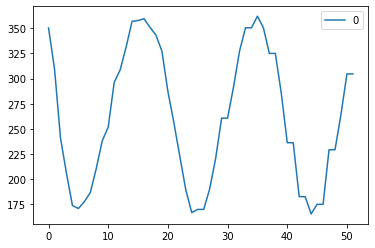

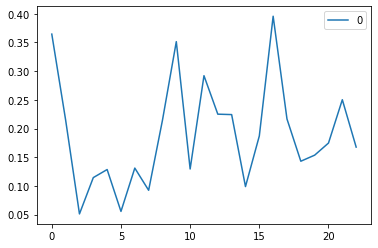

In [65]:
#主函数

#输入标准和当前两个json序列  输出评价矩阵 表示各个角的偏差
stanard_anglist=get_alldata("./standard/")#获取标准动作
now_anglist,now_xy_list,W=get_alldata("./now/",isRunning=True)#获取当前动作信息
times = getTimes(now_xy_list,0,"test")#计算运动个数 由于采用头部计数 传入0 头部的X即为各个List的第一个值
#print(times)
proposal=evaluate(stanard_anglist,now_anglist,int(times))
print(proposal)